In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Earth Engine Python client library
import ee
import geemap.core as geemap

# Resterio to load files
import rasterio
from rasterio.enums import Resampling

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split

import csv
import cv2  # OpenCV for faster resizing
import glob

from skimage.transform import resize

# TorchGeeo
# https://pytorch.org/blog/geospatial-deep-learning-with-torchgeo/
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader

from torchgeo.datamodules import InriaAerialImageLabelingDataModule
from torchgeo.datasets import CDL, Landsat7, Landsat8, VHR10, stack_samples
from torchgeo.samplers import RandomGeoSampler
from torchgeo.trainers import SemanticSegmentationTask

In [34]:
# Earth Engine Python client library config
# Authenticate (redirect to auth page if not)
ee.Authenticate()

True

In [35]:
# Get Google project
ee.Initialize(project = 'ee-nikolaydragomirovzhechev')

In [198]:
debug_enabled = False

Locate agricultural areas on large satellite images

Detect and outline the border of each plot within those areas

Classify the crops of these plots (wheat, tomatoes, corn …)

Scalability: A bank of images covering the whole world is available right away and being updated regularly

Data richness: Satellite images can provide a lot more information than simple pictures. Instead of a 3-band image of Red, Green and Blue pixels, some satellites can provide more than 15 features per pixel

Cost: Even though satellite imagery can be quite costly, some options are fully free, such as Sentinel 2

In [72]:
# Load the Landsat surface reflectance data
# Continuous Change Detection and Classification (CCDC) algorithm
dataset_Landsat = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")

longitude_min: The minimum longitude (western boundary) of your AOI.  
latitude_min: The minimum latitude (southern boundary) of your AOI.  
longitude_max: The maximum longitude (eastern boundary) of your AOI.  
latitude_max: The maximum latitude (northern boundary) of your AOI.

In [73]:
def define_area_of_interest(coordinates_urban, coordinates_forest):
    """Defines and returns areas of interests. Takes coordinates as parameters."""
    
    aoi_urban = ee.Geometry.Rectangle(coordinates_urban)  # Example: urban area
    aoi_forest = ee.Geometry.Rectangle(coordinates_forest)  # Example: forest area

    return aoi_forest, aoi_urban

In [77]:
dataset_filtered = dataset_Landsat.filterDate(start_date, end_date).filterBounds(aoi_forest)
print(dataset_filtered.size().getInfo())

1839


One of the most commonly used ones in an agricultural context is the NDVI (Normalized Difference Vegetation Index). This index is used to estimate the density of vegetation on the ground, which could serve to detect agricultural areas over a large image.

NDVI info:  
https://gisgeography.com/ndvi-normalized-difference-vegetation-index/

In [37]:
def compute_ndvi(image):
    ndvi = image.normalizedDifference(['B4', 'B5']).rename('NDVI')  # ['SR_B7', 'SR_B4']
    return image.addBands(ndvi)

Bands provide information about different spectral characteristics derived from Landsat satellite imagery.  
Key Bands in the Dataset:
Blue (B1):

Wavelength: ~450-520 nm
Useful for: Coastal and aerosol studies, distinguishing soil from vegetation, and monitoring water bodies.
Green (B2):

Wavelength: ~520-600 nm
Useful for: Assessing vegetation vigor, distinguishing between different types of vegetation, and monitoring aquatic systems.
Red (B3):

Wavelength: ~630-690 nm
Useful for: Discriminating between vegetation types, monitoring crop health, and assessing urban vs. rural areas.
Near-Infrared (NIR, B4):

Wavelength: ~770-900 nm
Useful for: Vegetation health, crop monitoring, and distinguishing between water bodies and land.
Shortwave Infrared 1 (SWIR1, B5):

Wavelength: ~1550-1750 nm
Useful for: Assessing vegetation moisture, soil moisture, and differentiating between snow, clouds, and other features.
Shortwave Infrared 2 (SWIR2, B6):

Wavelength: ~2080-2350 nm
Useful for: Monitoring droughts, soil moisture, and differentiating between snow/ice and clouds.
Thermal Infrared (TIR, B10):

Wavelength: ~10.4-12.5 µm
Useful for: Monitoring temperature, surface heat emissions, and identifying hot spots (e.g., wildfires).
Special Bands from the CCDC Algorithm:
Trend Coefficients (Slope and Intercept):

These bands represent the trend of surface reflectance values over time, generated by the CCDC algorithm. The slope indicates whether the reflectance has increased or decreased, while the intercept gives the baseline value at the beginning of the time series.
Seasonality Components:

CCDC decomposes time-series data into seasonal components, capturing cyclic patterns such as seasonal vegetation growth.
Breakpoint Count:

This band records the number of "breakpoints" where land cover change was detected by the CCDC algorithm over the 1999-2019 period.
Segment Number:

Each pixel in the CCDC dataset is divided into segments based on change over time. The segment number indicates which part of the time series the pixel belongs to (e.g., a stable segment or a transition due to land cover change).

In [81]:
dataset_with_ndvi = dataset_filtered.map(compute_ndvi)

# Get a median composite of the NDVI band
ndvi_composite = dataset_with_ndvi.select('NDVI').median()

# Visualize the result
m = geemap.Map()
m.centerObject(aoi_urban, 10)
m.addLayer(ndvi_composite, {'min': 0, 'max': 1, 'palette': ['white', 'green', 'brown']}, 'NDVI')
m

Map(center=[35.619108968819454, -109.85], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

#### Export Data to a Machine Learning-Compatible Format

This code performs an export task. Exported tasks can be saved in a personal Google Drive.

In [38]:
def export (data, region, description):
    '''Initiate Google Cloud export task. Provide data and region.'''
    # export task
    task = ee.batch.Export.image.toDrive(
        image = data,
        description = description,
        scale = 30, # The resolution of the image in meters
        region = region,
        fileFormat = 'GeoTIFF',
        maxPixels = 9485956438
    )
    
    task.start()

In [ ]:
export(ndvi_composite, aoi_urban)

Load exported results.

In [36]:
with rasterio.open('Datasets/Landsat/Landsat_NDVI_Export_01-0000000000-0000000000') as src:
    print("Image metadata:", src.meta)

    # Get number of bands
    num_bands = src.count
    print(f"Number of bands: {num_bands}")

Image metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2598, 'height': 1858, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -119.7000624512842,
       0.0, -0.00026949458523585647, 35.00060925750686)}
Number of bands: 1


In [39]:
 # Open the exported GeoTIFF
def load_geotiff_img(img_path, new_img_name):
    '''Loads and open downloaded GeoTIFF images.'''
    with rasterio.open('Datasets/{}'.format(img_path)) as src:
        # Read all bands into a NumPy array
        image_data = src.read()  # Shape: (bands, height, width)
    
        # Select the NDVI band (assuming it's stored in one of the bands)
        ndvi_band = src.read(1)  # Replace '1' with the correct band number if necessary
    
        # Normalize NDVI band between 0 and 1
        ndvi_normalized = (ndvi_band - ndvi_band.min()) / (ndvi_band.max() - ndvi_band.min())
    
        # If needed, convert the image data from a 3D to 4D format (e.g., for CNN input)
        image_data = np.transpose(image_data, (1, 2, 0))  # Shape: (height, width, bands)
    
        # Expand dimensions to add the channel, then resize using skimage's resize function
        X = np.expand_dims(ndvi_normalized, axis=-1)  # Shape: (height, width, 1)
        Resize the image to 256x256 (for CNN input) 
        X_resized = resize(X, (256, 256, 1), mode='reflect', anti_aliasing=True)
        X_resized = X_resized.astype(np.float32)
        print(f"Shape of resized X: {X_resized.shape}")  # Should be (256, 256, 1)
    
        # Get the image size (width, height)
        width = src.width
        height = src.height
        num_channels = src.count  # Number of bands
    
        # Define the new dimensions (e.g., 256x256 pixels)
        new_width, new_height = 256, 256
        scale_factor_x = new_width / width
        scale_factor_y = new_height / height
    
        # Resize the image using the 'average' resampling method
        resized_img = src.read(
            out_shape=(src.count, new_height, new_width),  # (num_bands, height, width)
            resampling=Resampling.average
        )
    
        # Save the resized image
        with rasterio.open(new_img_name, 'w', 
                           driver=src.driver, 
                           width=new_width, 
                           height=new_height, 
                           # count=src.count, 
                           count=resized_img.shape[-1],
                           dtype=src.dtypes[0], 
                           crs=src.crs, 
                           transform=src.transform) as dst:
            dst.write(resized_img)

In [78]:
def load_geotiff_img_advanced(img_path, new_img_name, selected_bands=None):
    """
    Loads, normalizes, resizes, and saves GeoTIFF images for model training.
    Works for single-band (e.g., NDVI) or multi-band images. 
    Ensures output shape is (256, 256, bands).
    """
    with rasterio.open(f'Datasets/{img_path}') as src:
        # Determine the bands to process
        num_bands = src.count
        bands_to_process = selected_bands if selected_bands else range(1, num_bands + 1)
        nodata_value = src.nodata

        # Initialize list to store resized bands
        resized_bands = []

        for band_idx in bands_to_process:
            # Read the band
            band_data = src.read(band_idx)

            # Handle no-data values
            if nodata_value is not None:
                band_data = np.where(band_data == nodata_value, np.nan, band_data)

            # Normalize the band
            band_clipped = np.clip(band_data, -1, 1) if selected_bands == ['NDVI'] else band_data
            band_normalized = (band_clipped + 1) / 2 if selected_bands == ['NDVI'] else band_data

            # Resize the band to 256x256
            band_resized = resize(band_normalized, (256, 256), mode='reflect', anti_aliasing=True).astype(np.float32)
            resized_bands.append(band_resized)

        # Stack bands for multi-band output
        resized_image = np.stack(resized_bands, axis=-1)  # Shape: (256, 256, bands)
        
        # Adjust transform for resizing
        transform_resized = src.transform * src.transform.scale(
            src.width / 256, src.height / 256
        )

        # Save the resized image
        with rasterio.open(
            new_img_name,
            'w',
            driver='GTiff',
            height=256,
            width=256,
            count=resized_image.shape[-1],  # Number of bands
            dtype='float32',
            crs=src.crs,
            transform=transform_resized,
        ) as dst:
            for i in range(resized_image.shape[-1]):  # Loop over bands
                dst.write(resized_image[:, :, i], i + 1)  # Write each band

        print(f"Saved resized image with {resized_image.shape[-1]} band(s) to {new_img_name}.")


In [41]:
def load_geotiff_img_optimized(img_path, selected_bands, output_size=(256, 256)):
    """
    Optimized function to load and preprocess GeoTIFF images.
    
    Args:
        img_path (str): Path to the GeoTIFF image.
        selected_bands (list): List of band indices or names to process.
        output_size (tuple): Target size for resizing (width, height).

    Returns:
        np.ndarray: Resized and processed image with shape (height, width, channels).
    """
    resized_bands = []
    output_width, output_height = output_size
    
    with rasterio.open(f'Datasets/{img_path}') as src:
        print("Available band indices:", src.indexes)
        print("Band descriptions:", src.descriptions)   
        
        # Determine the band indices to process
        if selected_bands == ['NDVI']:
            bands_to_process = [1]  # Assuming NDVI is stored in the first band
        else:
            bands_to_process = selected_bands
        
        for band_idx in bands_to_process:
            # Read the band
            band_data = src.read(band_idx)

            # Normalize and clip NDVI if applicable
            if selected_bands == ['NDVI']:
                band_data = np.clip(band_data, -1, 1)  # Clip to valid NDVI range
                band_data = (band_data + 1) / 2  # Normalize to [0, 1]
            else:
                # Normalize to [0, 1] based on actual range
                band_min, band_max = np.nanmin(band_data), np.nanmax(band_data)
                band_data = (band_data - band_min) / (band_max - band_min + 1e-10)
            
            # Replace NaN values with 0
            band_data = np.nan_to_num(band_data, nan=0.0)

            # Resize the band using OpenCV
            band_resized = cv2.resize(band_data, (output_width, output_height), interpolation=cv2.INTER_AREA)
            resized_bands.append(band_resized.astype(np.float32))
    
    # Stack bands into a single multi-channel image (height, width, channels)
    processed_image = np.stack(resized_bands, axis=-1)
    
    print(f"Processed image shape: {processed_image.shape}")  # Debugging
    return processed_image


#### Export images with labels

#### Convolutional Neural Network (CNN) model for classification  
https://www.tensorflow.org/tutorials/images/cnn

In [40]:
image_data_csv = pd.read_csv('image_labels.csv')

In [41]:
ndvi_normalized

array([[0.5157376 , 0.5081389 , 0.50550914, ..., 0.5893659 , 0.59007025,
        0.58577627],
       [0.52456516, 0.51278675, 0.5180901 , ..., 0.5771186 , 0.5890899 ,
        0.58999   ],
       [0.4697992 , 0.5124007 , 0.51131797, ..., 0.56913704, 0.57615364,
        0.58365315],
       ...,
       [0.50820225, 0.51105773, 0.5123773 , ..., 0.5650953 , 0.56014436,
        0.5519329 ],
       [0.5091227 , 0.51121265, 0.5116143 , ..., 0.56189483, 0.56021184,
        0.55427855],
       [0.5086429 , 0.5098837 , 0.511041  , ..., 0.55685735, 0.5673195 ,
        0.5656968 ]], dtype=float32)

In [186]:
# Define model for binary classification
height = 256
width = 256
num_channels = 3
num_channels_input = num_channels  # Depends on the image bands
num_classes = 1  # Binary classification (output either 0 or 1)

model = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, num_channels_input), padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')  # Sigmoid for binary classification
    ]
)

def load_images_from_directory(image_dir, target_height=256, target_width=256, num_channels=3):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".tif") or filename.endswith(".png"):  # Adjust based on your file types
            img_path = os.path.join(image_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Read image (adjust as needed)
            img = cv2.resize(img, (target_width, target_height))  # Resize image
            if img.ndim == 2:  # If grayscale, repeat channels
                img = np.stack([img] * num_channels, axis=-1)
            images.append(img)
    return np.array(images)

# Load and preprocess images
image_dir = 'Datasets/Model_Ready/'  # Replace with the actual path
X = load_images_from_directory(image_dir, target_height=256, target_width=256, num_channels=3)

# Normalize images
X_resized = X.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]

# Example labels (replace with actual labels for your dataset)
y_expanded = np.concatenate([np.repeat(0, X_resized.shape[0] // 2), np.repeat(1, X_resized.shape[0] // 2)])

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_resized, y_expanded, test_size=0.2, random_state=42)

# Compile [configure] the model with binary_crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now, you can train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4614 - loss: 0.6895 - val_accuracy: 0.3889 - val_loss: 1.4579
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 657ms/step - accuracy: 0.5264 - loss: 1.0071 - val_accuracy: 0.3889 - val_loss: 0.6943
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 612ms/step - accuracy: 0.4835 - loss: 0.6939 - val_accuracy: 0.3889 - val_loss: 0.6932
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 580ms/step - accuracy: 0.5499 - loss: 0.6931 - val_accuracy: 0.3889 - val_loss: 0.6934
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.5303 - loss: 0.6931 - val_accuracy: 0.3889 - val_loss: 0.6937
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.5655 - loss: 0.6929 - val_accuracy: 0.3889 - val_loss: 0.6939
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 559ms/step - accuracy: 0.5225 - loss: 0.6930 - val_accuracy: 0.3889 - val_loss: 0.6940
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step - accuracy: 0.5225 - loss: 0.6930 - val_accuracy: 0.3889 - val_loss: 0.

First trained results:

Epoch 1/10  
47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4699 - loss: 1.0823 - val_accuracy: 0.4973 - val_loss: 0..693  
Epoch 2/10  
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4916 - loss: 0.6934 - val_accuracy: 0.4973 - val_loss: 0. 0.6  
Epoch 3/10  
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4791 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6931  
Epoch 4/10  
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4822 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932  
Epoch 5/10  
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4857 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932  
Epoch 6/10  
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5116 - loss: 0.6931 - val_accuracy: 0.4973 - val_loss: 0.6932  
Epoch 7/32  
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4958 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932  
Epoch 8/10  
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4910 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932  
Epoch 9/10  
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5157 - loss: 0.6931 - val_accuracy: 0.4973 - val_loss: 0.6932  
Epoch 10/10  
47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.4977 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932  
<keras.src.callbacks.history.History at 0x29e1db63cd0>

 at 0x29e1db63cd0>

Both training accuracy and validation accuracy hover around 49-51% and do not improve significantly over the epochs

Both training and validation loss remain around 0.693 throughout the training. This is the typical loss value when using the binary_crossentropy loss function with random guessing.

A loss of 0.693 is equivalent to the log loss for random predictions (since -log(0.5) = 0.693), meaning the model is not learning meaningful patrns from the data.



Steps to improve on the above:

Data Exploration:

Explore the distribution of data, including NDVI values and labels. Make sure there’s a balance between the classes and that NDVI values are truly representative of the classes.

Model Adjustments:

Add more layers or experimenting with different layer configurations (e.g., using more filters or deeper convolutional layers).
Also, experiment with dropout layers to prevent overfitting, or regularization techniques like L2.

Feature Engineering:

Include additional features beyond NDVI (if possible), such as other spectral indices or geographical/contextual information.

Hyperparameter Tuning:

Adjust the learning rate of the optimizer (try decreasing it) or experiment with different optimizers (e.g., RMSprop or SGD).

More Training Data:

Export more data to ensure the model is seeing a representative variety of both classes. This is especially important if the model is stuck at a low performance threshold.

Check Data Alignment:

Ensure the images and labels are aligned correctly and that the preprocessing steps like resizing and normalization do not remove essential information.

Second training run:

Epoch 1/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 619s 1s/step - accuracy: 0.5079 - loss: 0.7330 - val_accuracy: 0.5033 - val_loss: 0.6931  
Epoch 2/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 609s 1s/step - accuracy: 0.5015 - loss: 0.6932 - val_accuracy: 0.5033 - val_loss: 0.6931  
Epoch 3/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.5012 - loss: 0.6931 - val_accuracy: 0.5033 - val_loss: 0.6931  
Epoch 4/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.4980 - loss: 0.6932 - val_accuracy: 0.5033 - val_loss: 0.6931  
Epoch 5/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 610s 1s/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.4967 - val_loss: 0.6932  
Epoch 6/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 32132s 59s/step - accuracy: 0.4901 - loss: 0.6932 - val_accuracy: 0.4967 - val_loss: 0.6932  
Epoch 7/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 996s 2s/step - accuracy: 0.5089 - loss: 0.6931 - val_accuracy: 0.5033 - val_loss: 0.6931  
Epoch 8/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 40294s 74s/step - accuracy: 0.4942 - loss: 0.6932 - val_accuracy: 0.4967 - val_loss: 0.6932  
Epoch 9/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 611s 1s/step - accuracy: 0.5069 - loss: 0.6932 - val_accuracy: 0.5033 - val_loss: 0.6931  
Epoch 10/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - accuracy: 0.5029 - loss: 0.6932 - val_accuracy: 0.4967 - val_loss: 0.6932  
<keras.src.callbacks.history.History at 0x27a9dd66610>


Increasing the data to 549 samples is not proving to be more accurate since the results appear around 50% and the model is still stagnating and not learning.

Increasing the model complexity and layers as a next step.

More Convolutional Layers: Each block includes a convolutional layer followed by batch normalization and max-pooling to extract more complex features  
Batch Normalization: This layer normalizes the inputs of the next layer, which often leads to faster training and better performance  
Increased Filters: The number of filters increases as we move deeper into the network to allow the model to capture more complex patterns  
Dropout: A dropout layer with a 50% dropout rate is added after the fully connected layer to reduce overfitting by randomly setting half of the neurons to zero during training.  
Activation and Loss Function: Since this is a binary classification task, the final layer uses sigmoid and binary_crossentropy as the loss function.  


In [45]:
# Define model for binary classification
height = 256
width = 256
num_channels_input = num_channels  # Depends on the image bands
num_classes = 1  # Binary classification (output either 0 or 1)

model = models.Sequential([
    # First convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(height, width, num_channels_input)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fifth convolutional block
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Fully connected layer with dropout
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting

    # Output layer with softmax for binary classification
    layers.Dense(num_classes, activation='sigmoid')
])

# Compile [configure] the model with binary_crossentropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Ensure your input data has the correct shape
X_resized = np.resize(X, (X.shape[0], 256, 256, 1))  # Shape: (num_samples, 256, 256, 1)
y_expanded = np.concatenate([np.repeat(0, X_resized.shape[0] // 2), np.repeat(1, X_resized.shape[0] // 2)])

# Split data into training and validation sets (e.g., 80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_resized, y_expanded, test_size=0.2, random_state=42)

# Train the model (assuming X_train is the image data and y_train are labels)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

C:\Users\zhech\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 5427s 10s/step - accuracy: 0.4940 - loss: 1.9221 - val_accuracy: 0.5003 - val_loss: 1.5989
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 132174s 241s/step - accuracy: 0.4962 - loss: 0.6936 - val_accuracy: 0.4967 - val_loss: 19.5083
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 2846s 5s/step - accuracy: 0.4944 - loss: 0.7043 - val_accuracy: 0.4997 - val_loss: 0.7133
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 2753s 5s/step - accuracy: 0.5005 - loss: 0.6942 - val_accuracy: 0.5033 - val_loss: 0.6931
Epoch 5/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 2721s 5s/step - accuracy: 0.4926 - loss: 0.6932 - val_accuracy: 0.4967 - val_loss: 0.6932
Epoch 6/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 2751s 5s/step - accuracy: 0.4928 - loss: 0.6935 - val_accuracy: 0.4972 - val_loss: 0.6940
Epoch 7/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 2866s 5s/step - accuracy: 0.4967 - loss: 0.6932 - val_accuracy: 0.4967 - val_loss: 0.6932
Epoch 8/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 2833s 5s/step - accuracy: 0.4969 - loss: 0.6

Epoch 1/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 5427s 10s/step - accuracy: 0.4940 - loss: 1.9221 - val_accuracy: 0.5003 - val_loss: 1.5989  
Epoch 2/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 132174s 241s/step - accuracy: 0.4962 - loss: 0.6936 - val_accuracy: 0.4967 - val_loss: 19.5083  
Epoch 3/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 2846s 5s/step - accuracy: 0.4944 - loss: 0.7043 - val_accuracy: 0.4997 - val_loss: 0.7133  
Epoch 4/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 2753s 5s/step - accuracy: 0.5005 - loss: 0.6942 - val_accuracy: 0.5033 - val_loss: 0.6931  
Epoch 5/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 2721s 5s/step - accuracy: 0.4926 - loss: 0.6932 - val_accuracy: 0.4967 - val_loss: 0.6932  
Epoch 6/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 2751s 5s/step - accuracy: 0.4928 - loss: 0.6935 - val_accuracy: 0.4972 - val_loss: 0.6940  
Epoch 7/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 2866s 5s/step - accuracy: 0.4967 - loss: 0.6932 - val_accuracy: 0.4967 - val_loss: 0.6932  
Epoch 8/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 2833s 5s/step - accuracy: 0.4969 - loss: 0.6936 - val_accuracy: 0.5033 - val_loss: 0.6931  
Epoch 9/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 2741s 5s/step - accuracy: 0.4981 - loss: 0.6933 - val_accuracy: 0.4983 - val_loss: 8.6245  
Epoch 10/10  
549/549 ━━━━━━━━━━━━━━━━━━━━ 2914s 5s/step - accuracy: 0.5031 - loss: 0.6934 - val_accuracy: 0.5033 - val_loss: 0.6931  
<keras.src.callbacks.history.History at 0x27a96c2b150>

In [187]:
# define a year to be used [used for further processing]
year = 2013
dataset_image_land_07 = ee.Image('LANDSAT/LE07/C02/T1_TOA/LE07_195027_19990725').select(
    ['B3', 'B2', 'B1']
)

dataset_land_07 = ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA').filterDate(
    '2001-01-01', '2002-12-31'
).select(['B3', 'B2', 'B1'])
trueColor321 = dataset_land_07.select(['B3', 'B2', 'B1'])
trueColor321Vis = {
    'min': 0.0,
    'max': 0.4,
    'gamma': 1.2,
}
m = geemap.Map()
m.set_center(6.746, 46.529, 6)
m.add_layer(trueColor321, trueColor321Vis, 'True Color (321)')
m

Map(center=[46.529, 6.746], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

The selection of bands B4 (red) and B5 (near-infrared) for calculating NDVI is correct for Landsat data. These are the standard bands used to assess vegetation health, as they emphasize the contrast between vegetation and other land cover types.

In [188]:
dataset_image_land_08 = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_199027_20170831').select(
    ['B3', 'B2', 'B1']
)

dataset_land_08 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA').filterDate(
    f'{year}-01-01', f'{year}-12-31'
).select(['B4', 'B5', 'B2'])
true_color_432 = dataset_land_08.select(['B4', 'B5'])
true_color_432_vis = {
    'min': 0.0,
    'max': 0.4,
}
m = geemap.Map()
m.set_center(6.746, 46.529, 6)
m.add_layer(true_color_432, true_color_432_vis, 'True Color (432)')
m

Map(center=[46.529, 6.746], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

Longitude: 7.171219710217076  
​Latitude: 47.24405762918135

In [189]:
# - first line is standard approach for encompassing the region
# geometry = ee.Geometry.Rectangle([-8, 37, 33,52])

# - second line of code is with above map points and a buffer
point = ee.Geometry.Point([40.28, 61.28])

# Create a buffer of 5 kilometers
buffer = point.buffer(5000)

# Use the buffer or the point as the region for export
geometry = buffer.bounds()

Projections:
https://developers.google.com/earth-engine/guides/projections

In [190]:
dataset_land_08.size()

In [47]:
dataset_landsat_with_ndvi = dataset_land_08.limit(20).map(compute_ndvi)

In [49]:
# Get a median composite of the NDVI band
ndvi_landsat_08_composite = dataset_landsat_with_ndvi.select('NDVI').median()

In [50]:
ndvi_landsat_08_composite

In [25]:
export(ndvi_landsat_08_composite, geometry, 'Landsat_08_NDVI_Export_06')

In [191]:
# Export the image, specifying the CRS, transform, and region.
def export_task (dataset, geometry, description):
    task = ee.batch.Export.image.toDrive(
        image=dataset,
        description=description,
        # crs=projection.get('crs'),
        # crsTransform=projection['transform'],
        scale=30, # 30 for Landsat
        region=geometry,
        maxPixels=1e13  # Increase max pixels to allow large exports
    )
    task.start()

EEException: User memory limit exceeded. > from entire dataset. Export in batches.

In [192]:
# Define a function to export each batch
def export_monthly_batch(collection, start_date, end_date, batch_id):
    # Filter collection by date
    monthly_collection = collection.filterDate(start_date, end_date) 
    
    # Create a composite image for the batch
    composite_image = monthly_collection.median()

    task = export_task(composite_image, geometry, 'Landsat_08_NDVI_Export_13')

    if debug_enabled:
        print(f"Exporting batch {batch_id} from {start_date} to {end_date}")

# Define the list of monthly batches
dates = [
    (f'{year}-01-01', f'{year}-01-31'),
    (f'{year}-02-01', f'{year}-02-28'),
    (f'{year}-03-01', f'{year}-03-31'),
    (f'{year}-04-01', f'{year}-04-30'),
    (f'{year}-05-01', f'{year}-05-31'),
    (f'{year}-06-01', f'{year}-06-30'),
    (f'{year}-07-01', f'{year}-07-31'),
    (f'{year}-08-01', f'{year}-08-31'),
    (f'{year}-09-01', f'{year}-09-30'),
    (f'{year}-10-01', f'{year}-10-31'),
    (f'{year}-11-01', f'{year}-11-30'),
    (f'{year}-12-01', f'{year}-12-31')
]

In [193]:
# Loop over each date range and export each month as a separate batch
for i, (start_date, end_date) in enumerate(dates):
    export_monthly_batch(dataset_land_08, start_date, end_date, i+1)

In [194]:
# Images to be formatted folder name
folder_name = 'Resize_function'
# loop through all downloaded images and save for model training
directory_data = os.fsencode(r"C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Landsat\{}".format(folder_name))

for file in os.listdir(directory_data):
    filename = os.fsdecode(file)
    load_geotiff_img_advanced("Landsat/Resize_function/{}".format(filename), "Datasets/Model_Ready/{}".format(filename))

Saved resized image with 3 band(s) to Datasets/Model_Ready/Landsat_08_NDVI_Export_13(1).tif.
Saved resized image with 3 band(s) to Datasets/Model_Ready/Landsat_08_NDVI_Export_13(2).tif.
Saved resized image with 3 band(s) to Datasets/Model_Ready/Landsat_08_NDVI_Export_13(3).tif.
Saved resized image with 3 band(s) to Datasets/Model_Ready/Landsat_08_NDVI_Export_13(4).tif.
Saved resized image with 3 band(s) to Datasets/Model_Ready/Landsat_08_NDVI_Export_13(5).tif.
Saved resized image with 3 band(s) to Datasets/Model_Ready/Landsat_08_NDVI_Export_13(6).tif.
Saved resized image with 3 band(s) to Datasets/Model_Ready/Landsat_08_NDVI_Export_13(7).tif.
Saved resized image with 3 band(s) to Datasets/Model_Ready/Landsat_08_NDVI_Export_13(8).tif.
Saved resized image with 3 band(s) to Datasets/Model_Ready/Landsat_08_NDVI_Export_13(9).tif.
Saved resized image with 3 band(s) to Datasets/Model_Ready/Landsat_08_NDVI_Export_13.tif.


C:\Users\zhech\anaconda3\Lib\site-packages\skimage\transform\_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
C:\Users\zhech\anaconda3\Lib\site-packages\skimage\transform\_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


In [18]:
# *legacy function

# Define Image Loading and Preprocessing Functions
def load_geotiff(filepath):
    with rasterio.open(filepath) as src:
        # Read all bands and return as numpy array
        image = src.read()  # Shape: (bands, height, width)
    return image

def preprocess_image(image):
    # Check the shape of the image
    if image.ndim == 3 and image.shape[0] == 1:  # Shape is (1, height, width)
        image = image[0]  # Remove the first dimension

    # Now check the shape again
    if len(image.shape) == 2:  # Grayscale image with shape (height, width)
        # Convert grayscale to 3 channels by stacking
        image = np.stack((image,) * 3, axis=-1)  # Shape becomes (height, width, 3)
    elif image.ndim == 3 and image.shape[2] == 3:  # RGB image
        pass  # Already in the correct format
    else:
        raise ValueError("Unexpected image shape: {}".format(image.shape))

    return image.astype(np.float32) / 255.0  # Normalize to [0, 1]


In [19]:
# *legacy function

# Directory containing GeoTIFF images
directory_model_data = r"C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready"

for file in os.listdir(directory_model_data):
    # Construct the full file path
    filename = os.path.join(directory_model_data, file)

    # Print the filename to debug
    if debug_enabled:
        print("Loading file:", filename)

    # Load and preprocess each image
    try:
        # Check if it's a file, not a directory
        if os.path.isfile(filename):
            image = load_geotiff(filename)
            processed_image = preprocess_image(image)
            if debug_enabled:
                print("Processed image shape:", processed_image.shape)
    except Exception as e:
        print(f"Error processing {filename}: {e}")

Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_1.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_2.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_3.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_4.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Landsat_08_NDVI_Export_05-0000000000-0000000000.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Landsat_08_NDVI_Export_05-0000000000-0000032768.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni

In [195]:
# *new functions

# Define Image Loading and Preprocessing Functions
def load_geotiff(filepath):
    with rasterio.open(filepath) as src:
        # Read all bands and return as numpy array
        image = src.read()  # Shape: (bands, height, width)
    return image

def preprocess_image(image):
    # Check the shape of the image
    if image.ndim == 3:
        if image.shape[0] == 1:  # Shape: (1, height, width)
            # Single-channel grayscale image, remove the first dimension and expand to 3 channels
            image = np.stack((image[0],) * 3, axis=-1)  # Shape becomes (height, width, 3)
        elif image.shape[0] == 3 and image.shape[1:] != image.shape[0:1]:  # Shape: (3, height, width)
            # Convert to (height, width, 3)
            image = np.transpose(image, (1, 2, 0))  # Swap axes to (height, width, bands)
        elif image.shape[2] == 3:  # Shape: (height, width, 3)
            pass  # Already in the correct format
        else:
            raise ValueError("Unexpected 3D image shape: {}".format(image.shape))
    elif image.ndim == 2:  # Grayscale image (height, width)
        # Convert grayscale to 3 channels by stacking
        image = np.stack((image,) * 3, axis=-1)  # Shape becomes (height, width, 3)
    else:
        raise ValueError("Unexpected image dimensions: {}".format(image.ndim))

    return image.astype(np.float32) / 255.0  # Normalize to [0, 1]

# Directory containing GeoTIFF images
directory_model_data = r"C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready"
debug_enabled = True  # Enable debugging

for file in os.listdir(directory_model_data):
    # Construct the full file path
    filename = os.path.join(directory_model_data, file)

    # Print the filename to debug
    if debug_enabled:
        print("Loading file:", filename)

    # Load and preprocess each image
    try:
        # Check if it's a file, not a directory
        if os.path.isfile(filename):
            image = load_geotiff(filename)
            processed_image = preprocess_image(image)
            if debug_enabled:
                print("Processed image shape:", processed_image.shape)
    except Exception as e:
        print(f"Error processing {filename}: {e}")

Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_1.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_10.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_11.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_12.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_13.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_14.tif
Processed image shape: (256, 256, 3)
Loading file: C:\Users\zhech\Desktop\Softuni\Machine Learning\Final Project\Datasets\Model_Ready\Image_15.tif
Processed

Create a Dataset Using TensorFlow’s tf.data API  
- streamline loading, preprocessing, and batching

In [196]:
labels_dict = {}
for filename in os.listdir(directory_model_data):
    if filename.endswith(".tif"):
        # Example label extraction logic, modify according to your naming convention
        label = int(filename.split("_")[1].split(".")[0])  # Extract label from filename
        labels_dict[filename] = label

if debug_enabled:
    print(labels_dict)

{'Image_1.tif': 1, 'Image_10.tif': 10, 'Image_11.tif': 11, 'Image_12.tif': 12, 'Image_13.tif': 13, 'Image_14.tif': 14, 'Image_15.tif': 15, 'Image_16.tif': 16, 'Image_17.tif': 17, 'Image_18.tif': 18, 'Image_19.tif': 19, 'Image_2.tif': 2, 'Image_20.tif': 20, 'Image_21.tif': 21, 'Image_22.tif': 22, 'Image_23.tif': 23, 'Image_24.tif': 24, 'Image_25.tif': 25, 'Image_26.tif': 26, 'Image_27.tif': 27, 'Image_28.tif': 28, 'Image_29.tif': 29, 'Image_3.tif': 3, 'Image_30.tif': 30, 'Image_31.tif': 31, 'Image_32.tif': 32, 'Image_33.tif': 33, 'Image_34.tif': 34, 'Image_35.tif': 35, 'Image_36.tif': 36, 'Image_37.tif': 37, 'Image_38.tif': 38, 'Image_39.tif': 39, 'Image_4.tif': 4, 'Image_40.tif': 40, 'Image_41.tif': 41, 'Image_42.tif': 42, 'Image_43.tif': 43, 'Image_44.tif': 44, 'Image_45.tif': 45, 'Image_46.tif': 46, 'Image_47.tif': 47, 'Image_48.tif': 48, 'Image_49.tif': 49, 'Image_5.tif': 5, 'Image_50.tif': 50, 'Image_51.tif': 51, 'Image_52.tif': 52, 'Image_53.tif': 53, 'Image_54.tif': 54, 'Image_55

In [197]:
# Filepaths to the images
filepaths_tif = glob.glob(directory_model_data + "/*.tif")
# Total number of samples
total_samples = len(filepaths_tif)

# Generator function to load and preprocess each image
def data_generator(filepaths, labels_dict):
    for filepath in filepaths:
        image = load_geotiff(filepath)  # Load the GeoTIFF image
        image = preprocess_image(image)   # Preprocess the image

        if debug_enabled:
            print(f"Image shape before yielding: {image.shape}")  # Debugging line

        # Convert the image to a TensorFlow tensor
        image = tf.convert_to_tensor(image, dtype=tf.float32)

        # If image is (256, 256, 1), convert it to (256, 256, 3)
        if image.shape[-1] == 1:
            image = tf.image.grayscale_to_rgb(image)

        # Extract filename and get the corresponding label
        filename = os.path.basename(filepath)
        label = labels_dict.get(filename)

        # Skip if no label is found
        if label is None:
            continue
        
        # Convert label to a TensorFlow tensor
        label = tf.convert_to_tensor(label, dtype=tf.float32)

        if debug_enabled:
            print("Yielding image shape:", image.shape, "and label:", label)
            
        yield image, label

# Create the dataset using a lambda function to pass labels_dict
dataset_land_t = tf.data.Dataset.from_generator(
    lambda: data_generator(filepaths_tif, labels_dict),
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),  # Image shape
        tf.TensorSpec(shape=(), dtype=tf.float32)  # Label shape
    )
)

# Shuffle, batch, and prefetch the dataset for efficient training
dataset_land_t = dataset_land_t.shuffle(buffer_size=len(filepaths_tif)).batch(32).prefetch(tf.data.AUTOTUNE)

# Check dataset shapes
for images, labels in dataset_land_t.take(1):
    print("Image batch shape:", images.shape)  # Should be (32, 256, 256, 3)
    print("Label batch shape:", labels.shape)  # Should be (32,)

Image shape before yielding: (256, 256, 3)
Yielding image shape: (256, 256, 3) and label: tf.Tensor(1.0, shape=(), dtype=float32)
Image shape before yielding: (256, 256, 3)
Yielding image shape: (256, 256, 3) and label: tf.Tensor(10.0, shape=(), dtype=float32)
Image shape before yielding: (256, 256, 3)
Yielding image shape: (256, 256, 3) and label: tf.Tensor(11.0, shape=(), dtype=float32)
Image shape before yielding: (256, 256, 3)
Yielding image shape: (256, 256, 3) and label: tf.Tensor(12.0, shape=(), dtype=float32)
Image shape before yielding: (256, 256, 3)
Yielding image shape: (256, 256, 3) and label: tf.Tensor(13.0, shape=(), dtype=float32)
Image shape before yielding: (256, 256, 3)
Yielding image shape: (256, 256, 3) and label: tf.Tensor(14.0, shape=(), dtype=float32)
Image shape before yielding: (256, 256, 3)
Yielding image shape: (256, 256, 3) and label: tf.Tensor(15.0, shape=(), dtype=float32)
Image shape before yielding: (256, 256, 3)
Yielding image shape: (256, 256, 3) and l

In [199]:
# Define input shape for Landsat imagery (e.g., 7 bands for Landsat 8)
input_shape = (256, 256, 3)

model = tf.keras.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third convolutional layer
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten and add dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),

    # Final layer - Adjust output units based on the task
    tf.keras.layers.Dense(1, activation='linear')  # e.g., for regression tasks
])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Adjust loss function as per your needs

# View the model architecture
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_148 (Conv2D)                  │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_149 (Conv2D)                  │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_150 (Conv2D)                  │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 256)                 │      67,109,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,512,961 (257.54 MB)

 Trainable params: 67,512,961 (257.54 MB)

 Non-trainable params: 0 (0.00 B)

Model summary shows a very high number of parameters in the fully connected layer dense_6, with over 67 million parameters. This occurs because the output from the last convolutional layer ((None, 32, 32, 256)) is flattened to (None, 262144) before being passed to dense_6, which has 256 units.

To reduce the parameter count and potentially improve the model’s efficiency, consider adding another pooling layer or using a Global Average Pooling layer after the last convolutional layer. Global pooling layers reduce spatial dimensions without needing a high number of trainable parameters, which is helpful for satellite imagery tasks.

Modifications
Use an Additional Pooling Layer: You can add a MaxPooling2D layer after the third Conv2D layer to further down-sample the spatial dimensions.

Use Global Average Pooling: Replace Flatten with GlobalAveragePooling2D to reduce the dimensionality more effectively. This will decrease the number of parameters by summarizing spatial dimensions.

Global Average Pooling Layer: Reduces the spatial dimensions to a single value per channel (from (None, 32, 32, 256) to (None, 256)), which drastically reduces the input size to the fully connected layer.

Impact on Parameters: This reduces the number of parameters in dense_6, making the model lighter and faster while retaining essential information.

In [209]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # Data Augmentation
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    
    # Convolutional layers
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'), # input_shape=input_shape
    # BatchNormalization layers after convolutional layers to stabilize training and improve performance
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # For regression tasks
])

model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_10 (RandomFlip)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_10 (RandomRotation)  │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_10 (RandomZoom)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_157 (Conv2D)                  │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_124              │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_61 (MaxPooling2D)      │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_158 (Conv2D)                  │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_125              │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_62 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_159 (Conv2D)                  │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_126              │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_63 (MaxPooling2D)      │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_21          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471,425 (1.80 MB)

 Trainable params: 470,529 (1.79 MB)

 Non-trainable params: 896 (3.50 KB)

In [210]:
#  Split the Dataset into Training and Validation Sets 
# train_size = int(0.8 * len(filepaths_tif))
# Calculate split sizes
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

train_dataset = dataset_land_t.take(train_size) #.repeat()
val_dataset = dataset_land_t.skip(train_size) #.repeat()

In [211]:
# Define callbacks and monitor validation loss and prevent overfitting
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5)
]

Optimizers: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

a. Regression (e.g., predicting NDVI, temperature, or other continuous variables)  
Loss Function:  
Mean Squared Error (MSE): Penalizes large errors more, suitable for most regression tasks.  
Mean Absolute Error (MAE): Less sensitive to outliers, useful if you have noisy data.  
Huber Loss: A combination of MSE and MAE, robust to outliers.  
Optimizer:  
Adam: A versatile and adaptive optimizer; often a good starting point.  
RMSprop: Works well for noisy or non-stationary data.  
SGD with Momentum: Can be effective but requires careful tuning.  
b. Classification (e.g., land cover types, urban vs. rural)  
Loss Function:  
Categorical Cross-Entropy: For multi-class classification when labels are one-hot encoded.  
Sparse Categorical Cross-Entropy: For multi-class classification with integer labels.  
Binary Cross-Entropy: For binary classification tasks.  
Optimizer:  
Adam: Often provides a good balance of speed and accuracy.  
SGD with Momentum: Good for fine-tuning pretrained models.  
c. Segmentation (e.g., crop boundaries, water bodies, urban areas)  
Loss Function:  
Binary Cross-Entropy or Categorical Cross-Entropy: For pixel-wise classification.  
Dice Loss: Focuses on the overlap between predicted and ground truth masks, often used for imbalanced datasets.  
IoU (Jaccard) Loss: Useful when intersection-over-union is a key evaluation metric.  
Optimizer:  
Adam: A common choice for segmentation tasks.  
SGD with Momentum: Can achieve better generalization on large datasets.  
d. Object Detection (e.g., detecting buildings, roads)  
Loss Function:  
Custom Loss Functions: Typically combines classification loss (e.g., cross-entropy) and regression loss (e.g., smooth L1) for bounding boxes.  
Optimizer:  
AdamW: Adam with weight decay; suitable for complex architectures like YOLO or Faster R-CNN.  

In [212]:
# Compile the model
model.compile(optimizer='adam', loss='mse')  # MSE for regression; adjust if needed

# Train the model
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/50
      3/Unknown 55s 5s/step - loss: 3293.9270

C:\Users\zhech\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - loss: 3251.4226 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - loss: 3069.0876 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 3154.6499 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 3081.8047 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 2702.0378 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 2300.9773 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 1928.3229 - learning_rate: 0.0010
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 1533.6788 - learning_rate: 0.0010
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 1024.0300 - learning_rate: 0.0010
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 777.4912 - learning_rate: 0.0010
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - loss: 898.4009 - learning_rate: 0.0010
Epoch 12/50
3/3 ━━━━━

'2017-01-01', '2017-01-02'  
'2022-01-01', '2022-01-02'


First run:  
Epoch 1/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.2760  
Epoch 2/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 1.2377  
Epoch 3/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 1.4225  
Epoch 4/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.9588  
Epoch 5/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1.0055  
Epoch 6/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 1.9402  
Epoch 7/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 1.0555  
Epoch 8/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.3748  
Epoch 9/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 1.4129  
Epoch 10/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 1.2818  

Second run:
Results show a better overall trend. The training loss is consistently decreasing with each epoch, indicating that the model is gradually learning from the data. Starting from around 49.8 and decreasing to 15.3 suggests that the model is effectively minimizing the loss, which is typically a sign of convergence.

Epoch 1/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 49.7952  
Epoch 2/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - loss: 46.4295  
Epoch 3/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 43.4524  
Epoch 4/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step - loss: 39.2551  
Epoch 5/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step - loss: 35.0007  
Epoch 6/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - loss: 31.6593  
Epoch 7/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - loss: 27.3199  
Epoch 8/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step - loss: 22.7143  
Epoch 9/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step - loss: 18.0280  
Epoch 10/10  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - loss: 15.3195  

To further evaluate and improve:

Increase Epochs: Running more epochs could help see if the loss continues to decrease or if it plateaus.
Validation Loss Tracking: Adding validation data will help observe if the model is overfitting. A diverging validation loss with a decreasing training loss would indicate overfitting.
Learning Rate: If the loss starts plateauing too soon, you could lower the learning rate further or try a learning rate scheduler for a gradual decrease.

Third run:  

Epoch 1/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 22.7203  
Epoch 2/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 20.6037  
Epoch 3/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 14.4283  
Epoch 4/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 18.2034  
Epoch 5/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 18.6051  
Epoch 6/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 19.6829  
Epoch 7/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 16.8309  
Epoch 8/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 16.3995  
Epoch 9/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 16.7076  
Epoch 10/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 18.6553  
Epoch 11/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 16.3321  
Epoch 12/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 17.2708  
Epoch 13/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 18.6530  
Epoch 14/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 17.1940  
Epoch 15/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 16.5669  
Epoch 16/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 16.7396  
Epoch 17/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 16.1727  
Epoch 18/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 14.5688  
Epoch 19/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 12.9904  
Epoch 20/20  
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 18.8812  

Change bands to infrared B4, B5 for better training and use this dataset. Years here are 2022 and 2023 - two days are taken for both years.

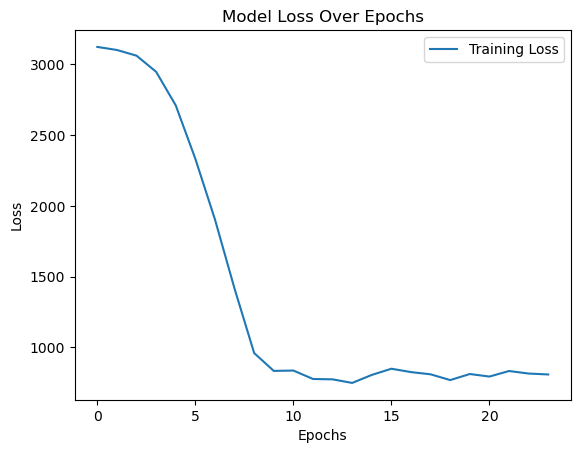

In [213]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [107]:
history.history

{'loss': [2495.2802734375,
  2485.255126953125,
  2422.899658203125,
  2264.542236328125,
  1967.07666015625,
  1615.8690185546875,
  1151.716552734375,
  811.6048583984375,
  643.9826049804688,
  720.32470703125,
  597.2861938476562,
  625.9951782226562,
  633.38134765625,
  634.9278564453125,
  618.8549194335938,
  644.3345947265625,
  658.4005737304688,
  607.0859985351562,
  632.1796264648438,
  635.8745727539062],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513]}

VGG16, ResNet50, IncetionV3, EfficientNet and DenseNet121 architectures

In [158]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the base model

In [162]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [168]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [178]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [179]:
# Add custom layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='linear')  # Regression task
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 8, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_18          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [180]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
    ]
)

Epoch 1/20
     38/Unknown 129s 2s/step - loss: 2510.7588

KeyboardInterrupt: 

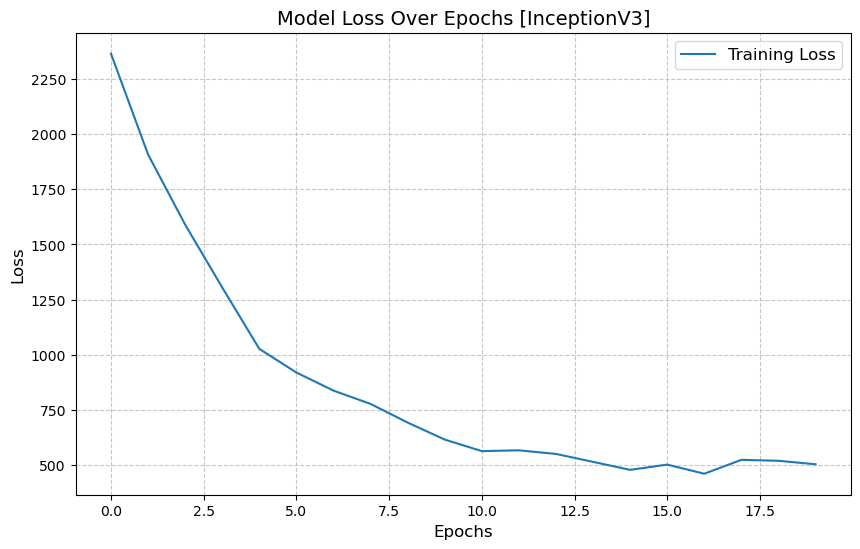

In [170]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss Over Epochs [DenseNet121]', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()